# セットアップ

In [1]:
# PyTorchバージョン変更
! pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# github からコードをコピー
! git clone -b feature/maskdetection https://github.com/tasotasoso/pytorch_ssd.git
%cd pytorch_ssd

# 学習済みパラメータをダウンロード
! wget -P weights https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 703.8 MB 22 kB/s 
     |████████████████████████████████| 6.6 MB 59.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.5.0+cu101 which is incompatible.
Cloning into 'pytorch_ssd'...
remote: Enumerating objects: 2583, done.
remote: Counting objects: 100% (865/865), done.
remote: Compressing objects: 100% (453/453), done.
remote: Total 258

In [2]:
# GPUの種類確認
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ae90ac0d-1239-7ae9-4244-daee16508ce2)


# 学習済みモデルによる物体検出（VOCクラス）

Loading weights into state dict...
Finished!


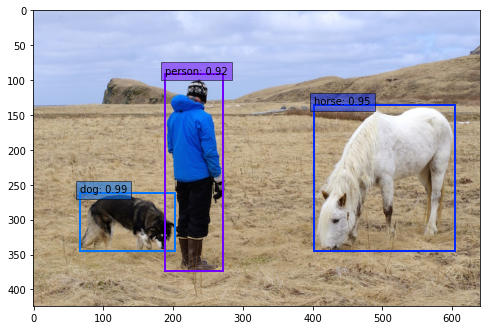

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
 
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2
from ssd import build_ssd
from matplotlib import pyplot as plt
from data import VOC_CLASSES as voc_labels

# GPUの設定
torch.cuda.is_available() 
torch.set_default_tensor_type('torch.cuda.FloatTensor')  
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

# SSDネットワークを定義し、学習済みパラメータを読み込む
net = build_ssd('test', 300, 21)   
net.load_weights('./weights/ssd300_mAP_77.43_v2.pth')
net = net.to(device)

# 物体検出関数 
def detect(image, labels):

    # 画像を(1,3,300,300)のテンソルに変換
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x = cv2.resize(image, (300, 300)).astype(np.float32)  
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)  
    xx = Variable(x.unsqueeze(0))    
     
    # 順伝播を実行し、推論結果を出力
    if torch.cuda.is_available():
      xx = xx.cuda()
    y = net(xx)

    # 表示設定 
    plt.figure(figsize=(8,8))
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    plt.imshow(rgb_image)
    currentAxis = plt.gca()

    # 推論結果をdetectionsに格納
    detections = y.data
    # 各検出のスケールのバックアップ
    scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
    
    # バウンディングボックスとクラス名を表示
    for i in range(detections.size(1)):
        j = 0
        # 確信度confが0.6以上のボックスを表示
        # jは確信度上位200件のボックスのインデックス
        # detections[0,i,j]は[conf,xmin,ymin,xmax,ymax]の形状
        while detections[0,i,j,0] >= 0.6:
            score = detections[0,i,j,0]
            label_name = labels[i-1]
            display_txt = '%s: %.2f'%(label_name, score)
            pt = (detections[0,i,j,1:]*scale).cpu().numpy()
            coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
            color = colors[i]
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
            j+=1
    plt.show()
    plt.close()
    return detections

# 物体検出実行
file = './data/person.jpg'
image = cv2.imread(file, cv2.IMREAD_COLOR) 
detections = detect(image, voc_labels)

# データセットBCCDの確認

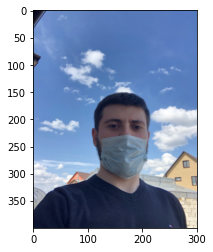

In [4]:
# BCCDデータの読み込み
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
testset = VOCDetection(VOC_ROOT, [('BCCD', 'test')], None, VOCAnnotationTransform())

# 10番目を指定
img_id = 10  

# 画像表示
image = testset.pull_image(img_id)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# 学習済みモデルをファインチューニング


In [5]:
from data import *
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from ssd import build_ssd
import os
import sys
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data as data
import numpy as np
import argparse
import warnings  
warnings.filterwarnings('ignore')  

# 初期設定
args = {'dataset':'BCCD',   
        'basenet':'vgg16_reducedfc.pth',
        'batch_size':32,
        'resume':'ssd300_mAP_77.43_v2.pth',
        'max_iter':500,
        'num_workers':4,  
        'cuda':True,
        'lr':0.001,
        'lr_steps':(8000, 10000, 12000),  
        'momentum':0.9,
        'weight_decay':5e-4,
        'gamma':0.1,
        'save_folder':'weights/'
       }

# Tensor作成時のデフォルトにGPU Tensorを設定
if torch.cuda.is_available():
    if args['cuda']:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    if not args['cuda']:
        print("WARNING: It looks like you have a CUDA device, but aren't " +
              "using CUDA.\nRun with --cuda for optimal training speed.")
        torch.set_default_tensor_type('torch.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# 訓練データの設定
cfg = voc
dataset = VOCDetection(root=VOC_ROOT,
                       transform=SSDAugmentation(cfg['min_dim'],
                                                 MEANS))

# ネットワークの定義
ssd_net = build_ssd('train', cfg['min_dim'], cfg['num_classes'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ssd_net.to(device)

# 学習済みパラメータのロード
if args['resume']:
    print('Resuming training, loading {}...'.format(args['resume']))
    ssd_net.load_weights(args['save_folder'] + args['resume'])  
else:
    vgg_weights = torch.load(args['save_folder'] + args['basenet'])
    print('Loading base network...')
    ssd_net.vgg.load_state_dict(vgg_weights)

# GPU設定
if args['cuda']:
    net = torch.nn.DataParallel(ssd_net)
    cudnn.benchmark = True

# learning_rate の段階調整関数
def adjust_learning_rate(optimizer, gamma, step):
    lr = args['lr'] * (gamma ** (step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# xavierの初期化関数
def xavier(param):
    init.xavier_uniform_(param)

# パラメータ初期化関数
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()

# 新規学習時のパラメータ初期化
if not args['resume']:
    print('Initializing weights...')
    ssd_net.extras.apply(weights_init)
    ssd_net.loc.apply(weights_init)
    ssd_net.conf.apply(weights_init)

# 損失関数の設定
criterion = MultiBoxLoss(cfg['num_classes'], 0.5, True, 0, True, 3, 0.5,
                         False, args['cuda'])

# 最適化手法の設定
optimizer = optim.SGD(net.parameters(), lr=args['lr'], momentum=args['momentum'],
                      weight_decay=args['weight_decay'])

# 訓練モード
net.train()

# データローダの設定
data_loader = data.DataLoader(dataset, args['batch_size'],
                              num_workers=args['num_workers'],
                              shuffle=True, collate_fn=detection_collate,
                              pin_memory=True)

# 学習ループ
step_index = 0
batch_iterator = None
epoch_size = len(dataset) // args['batch_size']

for iteration in range(args['max_iter']):   
    if (not batch_iterator) or (iteration % epoch_size ==0):
        batch_iterator = iter(data_loader)
        loc_loss = 0
        conf_loss = 0

    # lrの調整
    if iteration in args['lr_steps']:
        step_index += 1
        adjust_learning_rate(optimizer, args['gamma'], step_index)
        
    # バッチサイズ分のデータをGPUへ
    images, targets = next(batch_iterator)
    images = images.to(device) 
    targets = [ann.to(device) for ann in targets]

    # 順伝播
    t0 = time.time()
    out = net(images)

    # 逆伝播
    optimizer.zero_grad()
    loss_l, loss_c = criterion(out, targets)
    loss = loss_l + loss_c
    loss.backward()
    optimizer.step()
    t1 = time.time()
    loc_loss += loss_l.item()
    conf_loss += loss_c.item()
    
    #ログの出力
    if iteration % 10 == 0:
        print('timer: %.4f sec.' % (t1 - t0))
        print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.item()), end=' ')

# 学習済みモデルの保存
torch.save(ssd_net.state_dict(),
           args['save_folder'] + '' + args['dataset'] + '.pth')

Resuming training, loading ssd300_mAP_77.43_v2.pth...
Loading weights into state dict...
Finished!
timer: 8.3274 sec.
iter 0 || Loss: 18.3141 || timer: 0.3797 sec.
iter 10 || Loss: 5.7845 || timer: 0.3662 sec.
iter 20 || Loss: 4.1397 || timer: 0.3814 sec.
iter 30 || Loss: 4.1447 || timer: 0.3642 sec.
iter 40 || Loss: 3.1655 || timer: 0.5051 sec.
iter 50 || Loss: 3.4666 || timer: 0.3902 sec.
iter 60 || Loss: 2.6203 || timer: 0.4748 sec.
iter 70 || Loss: 3.3267 || timer: 0.4225 sec.
iter 80 || Loss: 2.5741 || timer: 0.3754 sec.
iter 90 || Loss: 3.0258 || timer: 0.4048 sec.
iter 100 || Loss: 2.4367 || timer: 0.3688 sec.
iter 110 || Loss: 2.7689 || timer: 0.4338 sec.
iter 120 || Loss: 2.6800 || timer: 0.4085 sec.
iter 130 || Loss: 2.0835 || timer: 0.5273 sec.
iter 140 || Loss: 2.1137 || timer: 0.4044 sec.
iter 150 || Loss: 2.8443 || timer: 0.3786 sec.
iter 160 || Loss: 2.3151 || timer: 0.4066 sec.
iter 170 || Loss: 2.1186 || timer: 0.3874 sec.
iter 180 || Loss: 1.7783 || timer: 0.4421 sec.

# ファインチューニングしたモデルで物体検知（BCCDクラス）


Loading weights into state dict...
Finished!


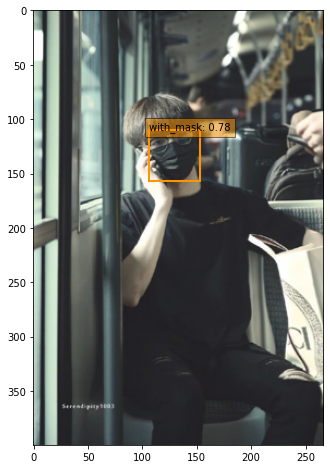

In [6]:
import os
import sys
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
 
from ssd import build_ssd
 
# SSDネットワークの定義とパラメータのロード
net = build_ssd('test', 300, 21)    
net.load_weights('./weights/BCCD.pth')
 
# BCCD_test 読み込み
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
from data import BCCD_CLASSES as bccd_labels
testset = VOCDetection(VOC_ROOT, [('BCCD', 'test')], None, VOCAnnotationTransform())

# 画像の読み込み
img_id = 42  
image = testset.pull_image(img_id)

# 物体検出
detections = detect(image, bccd_labels)

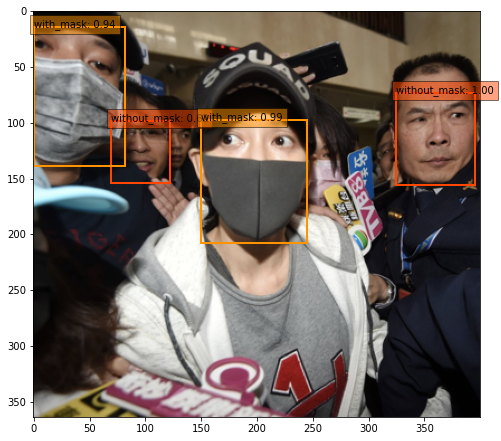

In [7]:
# 画像の読み込み
img_id = 55  
image = testset.pull_image(img_id)

# 物体検出
detections = detect(image, bccd_labels)